# Simple Balance Calculations

In [17]:
import numpy as np
import matplotlib.pyplot as plt

## Linear Bed Profile

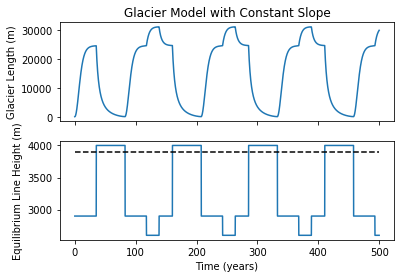

[[  1.07502150e+01   1.64474739e+04]
 [  4.18908378e+01   8.23128615e+03]
 [  9.31418628e+01   1.64512930e+04]
 [  1.22232445e+02   2.90694920e+04]
 [  1.42912858e+02   2.69305530e+04]
 [  1.66983340e+02   8.26137066e+03]
 [  2.18264365e+02   1.64512800e+04]
 [  2.47354947e+02   2.90694909e+04]
 [  2.68035361e+02   2.69305530e+04]
 [  2.92105842e+02   8.26137066e+03]
 [  3.43386868e+02   1.64512800e+04]
 [  3.72477450e+02   2.90694909e+04]
 [  3.93157863e+02   2.69305530e+04]
 [  4.17228345e+02   8.26137066e+03]
 [  4.68509370e+02   1.64512800e+04]]


In [3]:
b0 = 3900.
s = .1
beta = .007
alpha = 3.
nu = 10. 
width = 10.
## Run-time-determined variables
dt = .01
steps = 50000
times = np.linspace(0., dt * steps, steps)
lengths = np.full(steps, 1.)
equi = np.full(steps, 2900.)
equi_steps = [2900.,4000., 2900, 2600.]
equi_i = 1
step_moment = (0., 0., 0)
e_th = np.array([[0., 0.]])

def bed_height_lin(x):
    return b0 - s * x

def bed_mean_lin(ti):
    return b0 - s * lengths[ti] / 2.

def ice_mean_h(ti):
    return alpha / (1 + nu * s) * np.sqrt(lengths[ti])

def balance_r(h):
    return beta * (h - equi[ti])

def mass_balance_lin(ti):
    return beta * (bed_mean_lin(ti) + ice_mean_h(ti) - equi[ti]) * lengths[ti] * width

def dl_dt_lin(ti, forcing=0.):
    right_t = 3. * alpha / (2. * (1 + nu * s)) * np.sqrt(lengths[ti])
    # left_t = alpha * nu / pow(1 + nu * s, 2) * pow(lengths[ti], 3. / 2.) * 0. # Slope is constant  
    left_t =  0.
    if (np.isclose(right_t - left_t, 0.)):
        return 0.
    return pow(right_t - left_t, -1.) * (mass_balance_lin(ti) + forcing)

for i in range(len(lengths) - 1):
    lengths[i + 1] = lengths[i] + dt * dl_dt_lin(i)
    if (abs(lengths[i + 1] - lengths[i]) < .1):
        # equi[i + 1] = equi[i] * 1.16
        equi[i + 1] = equi_steps[equi_i]
        
        # Calculate e-fold time
        cur_moment = (times[i], lengths[i], i)
        _e_height = (2. / 3 ) * (cur_moment[1] - step_moment[1]) + step_moment[1]
        _e_time = times[np.argmin(np.abs(lengths[step_moment[2]:i] - _e_height)) + step_moment[2]]
        e_th = np.append(e_th, [[_e_time, _e_height]], axis=0)
        step_moment = cur_moment
        
        # Step function
        equi_i = (equi_i + 1) if (equi_i + 1 < len(equi_steps)) else 0
    else:
        equi[i + 1] = equi[i]
e_th = e_th[1:]
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times, lengths)
ax1.set_ylabel("Glacier Length (m)")
ax1.set_title("Glacier Model with Constant Slope")
ax2.plot(times, equi)
ax2.plot([times[0], times[-1]], [b0, b0], 'k--')
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Equilibrium Line Height (m)")
plt.show()

print e_th

## Concave Bed Profile

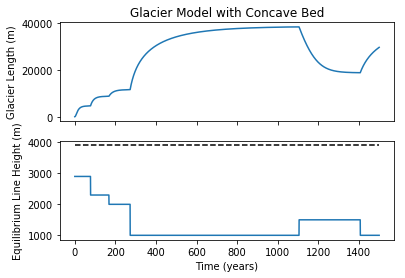

[[  1.83012201e+01   3.05328151e+03]
 [  9.42062804e+01   7.31113906e+03]
 [  1.90112674e+02   1.05502879e+04]
 [  3.84825655e+02   2.93086044e+04]
 [  1.17927862e+03   2.52139691e+04]]
1.0


In [4]:
b0 = 3900.
ba = 0.
xl = 7000.
# s = .1
beta = .007
alpha = 3.
nu = 10. 
width = 1.
## Run-time-determined variables
dt = .1
steps = 15000
times = np.linspace(0., dt * steps, steps)
lengths = np.full(steps, 1.)
equi = np.full(steps, 2900.)
equi_steps = [2900., 2300., 2000., 1000., 1500., 1000.]
equi_i = 1
step_moment = (0., 0., 0)
e_th = np.array([[0., 0.]])

def bed_height_con(x):
    return ba + b0 * np.exp(-x / xl)

def bed_mean_con(ti):
    return ba + (xl * b0) / lengths[ti] * (1. - np.exp(-lengths[ti] / xl))

def slope_mean(ti):
    return b0 * (1. - np.exp(-lengths[ti] / xl)) / lengths[ti]

def ds_dl_con(ti):
    return -b0 * (1. - np.exp(-lengths[ti]/xl)) / pow(lengths[ti], 2) +\
           b0 * np.exp(-lengths[ti] / xl) / xl / lengths[ti]

def ice_mean_h(ti):
    return alpha / (1 + nu * slope_mean(ti)) * np.sqrt(lengths[ti])

def balance_r(h):
    return beta * (h - equi[ti])

def mass_balance_con(ti):
    return beta * (bed_mean_con(ti) + ice_mean_h(ti) - equi[ti]) * lengths[ti] * width

def dl_dt_con(ti, forcing=0.):
    s = slope_mean(ti)
    right_t = 3. * alpha / (2. * (1 + nu * s)) * np.sqrt(lengths[ti])
    left_t = alpha * nu / pow(1 + nu * s, 2) * pow(lengths[ti], 3. / 2.) * ds_dl_con(ti)
    if (np.isclose(right_t - left_t, 0.)):
        return 0.
    return pow(right_t - left_t, -1.) * (mass_balance_con(ti) + forcing)

for i in range(len(lengths) - 1):
    lengths[i + 1] = lengths[i] + dt * dl_dt_con(i)
    if (abs(lengths[i + 1] - lengths[i]) < .1):
        # equi[i + 1] = equi[i] / 2.
        equi[i + 1] = equi_steps[equi_i]
        # Calculate e-fold time
        cur_moment = (times[i], lengths[i], i)
        _e_height = (2. / 3 ) * (cur_moment[1] - step_moment[1]) + step_moment[1]
        _e_time = times[np.argmin(np.abs(lengths[step_moment[2]:i] - _e_height)) + step_moment[2]]
        e_th = np.append(e_th, [[_e_time, _e_height]], axis=0)
        step_moment = cur_moment
        # Step function
        equi_i = (equi_i + 1) if (equi_i + 1 < len(equi_steps)) else 0
    else:
        equi[i + 1] = equi[i]
e_th = e_th[1:]
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times, lengths)
ax1.set_ylabel("Glacier Length (m)")
ax1.set_title("Glacier Model with Concave Bed")
ax2.plot(times, equi)
ax2.plot([times[0], times[-1]], [b0, b0], 'k--')
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Equilibrium Line Height (m)")
plt.show()

#fig = plt.figure()
#plt.plot(np.arange(7000), bed_height(np.arange(7000)), label="Concave Bed Shape")
#plt.xlabel("Distance from top (m)")
#plt.ylabel("Height (m)")
#plt.title("Concave Bed Shape")
#plt.show()
print e_th
print min(lengths)

## Calving Flux

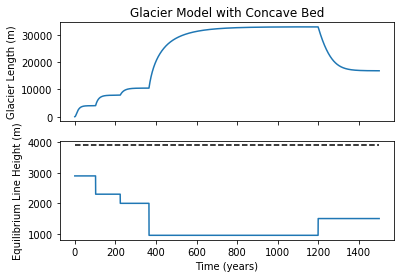

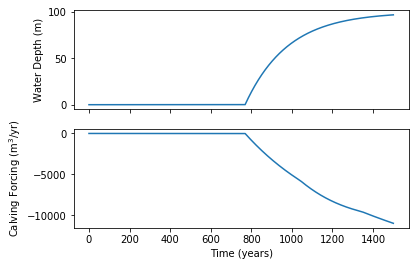

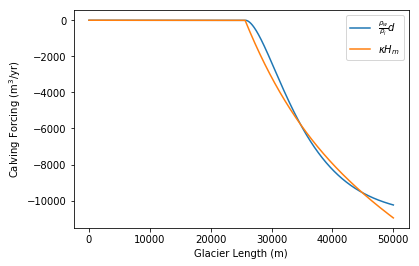

[[  1.86012401e+01   2.69098460e+03]
 [  1.18407894e+02   6.60719044e+03]
 [  2.44316288e+02   9.62286482e+03]
 [  4.43129542e+02   2.54748525e+04]]


In [5]:
b0 = 3900.
ba = -100.
xl = 7000.
# s = .1
beta = .007
alpha = 3.
nu = 10. 
width = 1.

# Calving
calv_p = 1.
kfrac = .3
water_d, ice_d = (1000., 917.)
## Run-time-determined variables
dt = .1
steps = 15000
times = np.linspace(0., dt * steps, steps)
lengths = np.full(steps, 1.)
equi = np.full(steps, 2900.)
equi_steps = [2900., 2300., 2000., 950., 1500., 1000.]
equi_i = 1
# e-folding
step_moment = (0., 0., 0)
e_th = np.array([[0., 0.]])

# print -xl * np.log(-ba/b0)
def water_depth_con(ti):
    return -bed_height_con(lengths[ti]) if (bed_height_con(lengths[ti]) < 0.0) else 0.0

def water_depth_lin(ti):
    return -bed_height_lin(lengths[ti]) if (bed_height_lin(lengths[ti]) < 0.0) else 0.0

def calving_depth(ti, mode='con'):
    if mode is 'con':
        w_depth = water_depth_con(ti)
    else:
        w_depth = water_depth_lin(ti)
    return -calv_p * w_depth * width * np.max([kfrac * ice_mean_h(ti), water_d / ice_d * w_depth])

for i in range(len(lengths) - 1):
    lengths[i + 1] = lengths[i] + dt * dl_dt_con(i, calving_depth(i))
    if (abs(lengths[i + 1] - lengths[i]) < .01 and (step_moment[1] != times[i])):
        # equi[i + 1] = equi[i] / 2.
        equi[i + 1] = equi_steps[equi_i]
        # Calculate e-fold time
        cur_moment = (times[i], lengths[i], i)
        _e_height = (2. / 3 ) * (cur_moment[1] - step_moment[1]) + step_moment[1]
        _e_time = times[np.argmin(np.abs(lengths[step_moment[2]:i] - _e_height)) + step_moment[2]]
        e_th = np.append(e_th, [[_e_time, _e_height]], axis=0)
        step_moment = cur_moment
        # Step function
        equi_i = (equi_i + 1) if (equi_i + 1 < len(equi_steps)) else 0
    else:
        equi[i + 1] = equi[i]
e_th = e_th[1:]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times, lengths)
ax1.set_ylabel("Glacier Length (m)")
ax1.set_title("Glacier Model with Concave Bed")
ax2.plot(times, equi)
ax2.plot([times[0], times[-1]], [b0, b0], 'k--')
ax2.set_ylabel("Equilibrium Line Height (m)")
ax2.set_xlabel("Time (years)")
plt.show()

# Check calving depth
lengths = np.linspace(1., 50000., 15000)
_waterd = np.empty(steps)
_calving = np.empty(steps)
_comb = np.empty((2, steps))
for i in range(len(lengths)):
    _waterd[i] = water_depth_con(i)
    _calving[i] = calving_depth(i)
    
    #w_depth = _waterd[i]
    _comb[0,i] = -calv_p * _waterd[i] ** 2 * width *  water_d / ice_d
    _comb[1,i] = -calv_p * _waterd[i] * width *  kfrac * ice_mean_h(i)
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times, _waterd)
ax1.set_ylabel("Water Depth (m)")
ax2.plot(times, _calving)
ax2.set_ylabel("Calving Forcing (m$^3$/yr)")
ax2.set_xlabel("Time (years)")
plt.show()


f = plt.figure()
plt.plot(lengths, _comb[0,:], label='$\\frac{\\rho_w}{\\rho_i}d$')
plt.plot(lengths, _comb[1,:], label='$\\kappa H_m$')
plt.xlabel("Glacier Length (m)")
plt.ylabel("Calving Forcing (m$^3$/yr)")
plt.legend()
plt.show()

#_ice_mean_h = np.array([ice_mean_h(i) for i in range(len(lengths))])
#plt.plot(times, _ice_mean_h)
#plt.show()

#fig = plt.figure()
#plt.plot(np.arange(7000), bed_height(np.arange(7000)), label="Concave Bed Shape")
#plt.xlabel("Distance from top (m)")
#plt.ylabel("Height (m)")
#plt.title("Concave Bed Shape")
#plt.show()
print e_th

## ELS Data from external files

In [6]:
def read_els_data(filename):
    import os.path
    assert(os.path.exists(filename))
    return np.genfromtxt(filename, delimiter='\t')

### Concave Bed

871.97


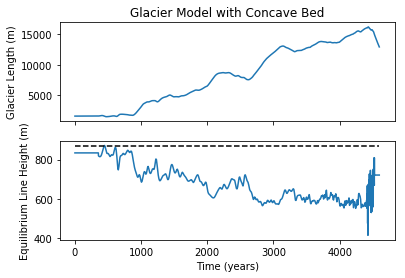

In [25]:
b0 = 870.
ba = 0.
xl = 7000.
# s = .1
beta = .007
alpha = 3.
nu = 10. 
width = 1.

## Run-time-determined variables
dt = 1.
steps = 4600
times = np.linspace(0., dt * steps, steps)
lengths = np.full(steps, 1.)

equi_per= read_els_data(".\\ELS_data_spitsbergen.txt")
equi = np.full(steps, equi_per[0,1])
equi_steps = equi_per.T[1][0:2]

# Custom Geometry


#coordinates = [[17.51806823248436,79.35771072001703], [17.34105444999151,79.33954934516657],
#               [17.28735106260403,79.28482535062538], [17.28132213793325,79.22592416747455],
#               [17.31551766413089,79.1776906844552 ], [17.31885134701311,79.14110861124895],
#               [17.22565063381898,79.11049960734091], [17.1947585771082, 79.06589866869315 ],
#               [17.21567039201253,79.02996481586489], [17.26296874145393,78.99655772735513]]
#coordinates = np.transpose(coordinates)
#coordinates = np.array([coordinates[1], coordinates[0]])
#np.savetxt("veteranen_coords.csv", coordinates, delimiter=',')
#heights = [geocoder.elevation(coord).meters for coord in coordinates]
# e-folding
print max(equi_per.T[1])

def calc_e_folding_t(i, stp_moment, e_list):
    # Calculate e-fold time
    cur_moment = (times[i], lengths[i], i)
    _e_height = (2. / 3 ) * (cur_moment[1] - stp_moment[1]) + stp_moment[1]
    _e_time = times[np.argmin(np.abs(lengths[stp_moment[2]:i] - _e_height)) + stp_moment[2]]
    e_list = np.append(e_list, [[_e_time, _e_height]], axis=0)
    return (cur_moment, e_list)

def run_simulation(bed_profile='con', equi_shape=None, use_calving=False):
    equi_i = 1
    step_moment = (0., 0., 0)
    e_th = np.array([[0., 0.]])
    
    for i in range(len(lengths) - 1):
        forcing = calving_depth(i, bed_profile) if use_calving else 0.
        dl_dt = dl_dt_con(i, forcing) if bed_profile is 'con' else dl_dt_lin(i, forcing)
        
        lengths[i + 1] = lengths[i] + dt * dl_dt
        if (abs(lengths[i + 1] - lengths[i]) < .1) and (equi_shape is None):
            equi[i + 1] = equi_steps[equi_i] 
            # Calculate e-fold time
            step_moment, e_th = calc_e_folding_t(i, step_moment, e_th)
            # Step function
            equi_i = (equi_i + 1) if (equi_i + 1 < len(equi_steps)) else 0
        elif (equi_shape is not None):
            t_offset = i * dt + equi_shape[0,0]
            t_index = 0
            while equi_shape[t_index, 0] < t_offset and (t_index < (equi_shape.shape[0] - 1)):
                t_index = t_index + 1
            equi[i + 1] = equi_shape[t_index][1]
        else:
            equi[i + 1] = equi[i]
    return e_th[1:]

#run_simulation('con', equi_per)
# Calculate Stable height for first value
start_h = run_simulation('con').T[1,-1]
lengths = np.full(steps, start_h)
run_simulation('con', equi_per)
    
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(times, lengths)
ax1.set_ylabel("Glacier Length (m)")
ax1.set_title("Glacier Model with Concave Bed")
ax2.plot(times, equi)
ax2.plot([times[0], times[-1]], [b0, b0], 'k--')
ax2.set_xlabel("Time (years)")
ax2.set_ylabel("Equilibrium Line Height (m)")
plt.show()

In [8]:
print(max(equi_per.T[0]) - min(equi_per.T[0]))

4525.0
